In [2]:
# Paths & URLs

import os

# Enable CUDA stacktrace reporting for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Directorio base
#PATH_BASE = '/content/drive/MyDrive/proximity'
#PATH_BASE = 'C:\\Users\\User\\Documents\\Proyecto Proximity'
PATH_BASE = 'E:\\files\\Documents\\Proyecto Proximity'

# Data release actual
DR70_PATH = os.path.join(PATH_BASE, 'DR70')
DR70_CT_PATH = os.path.join(DR70_PATH, 'datalake_sorted')
DR70_LABELS_PATH = os.path.join(DR70_PATH, 'labels.csv')

# Data release 176
DR176_PATH = os.path.join(PATH_BASE, 'DR176')
DR176_CT_PATH = os.path.join(DR176_PATH, 'DR176_studies')
DR176_LABELS_PATH = os.path.join(PATH_BASE, 'reports_with_label.csv')

# CTs in Nibabel format
CT_NIBABEL_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs')

# Embeddings visuales de CTs
#CT_EMBEDDINGS_PATH = DATA_RELEASE_PATH + '/visual_embeddings'


# Etiquetas de los CTs del data release actual
#CT_LABELS_CSV_PATH = DATA_RELEASE_PATH + '/labels.csv'

# Data release (CTs + etiquetas) organizados en un DataFrame
#CT_DATASET_DF_HDF_PATH = os.path.join(PATH_BASE, 'dataset_df.h5')
#CT_DATASET_DF_PICKLE_PATH = os.path.join(PATH_BASE, 'dataset_df.pickle')

# URLs de modelos visuales
#RESNET18_URL = 'microsoft/resnet-18'

# Path que contiene los resnet50 embeddings de CTs del data release actual
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18')
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'reshaped_averaged')

# Path de modelos entrenados en base a tripletas
TRIPLET_MODELS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets')
TRIPLET_CHECKPOINTS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets', 'checkpoints')

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torchio as tio
from torch.utils.data import Dataset, random_split, RandomSampler, BatchSampler
from scipy.spatial.distance import hamming
import random
import logging

# Set seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

logging.basicConfig(level=logging.INFO)

class ProximityCTDataset(tio.SubjectsDataset):
    def __init__(self, ct_base_path, ct_image_ids, ct_labels_path):
        
        self.labels_df = pd.read_csv(
            ct_labels_path, 
            header=0, 
            #index_col=0, 
            dtype={'CT': str, 'condensacion': int, 'nodulos': int, 'quistes': int}
        )
        
        # Mark those samples that have non-binary label values as not valid
        self.labels_df['labels_are_valid'] = self.labels_df.apply(self._determine_valid_labels, axis=1)

        s_list = []
        for s_id in ct_image_ids:
            label_attribs = self._get_ct_label_data(s_id)
            s = tio.Subject(
                t1 = tio.ScalarImage(os.path.join(ct_base_path, s_id)),
                image_path = os.path.join(ct_base_path, s_id),
                **label_attribs
            )
            s_list.append(s)
        '''
        subject_list = [dirname for dirname in os.listdir(ct_images_path)]
        s_list = []
        for s_id in subject_list:
            label_attribs = self.get_ct_label_data(s_id)
            s = tio.Subject(
                t1 = tio.ScalarImage(os.path.join(ct_images_path, s_id)),
                image_path = os.path.join(ct_images_path, s_id),
                embedding = None,
                **label_attribs
            )
            s_list.append(s)
        '''
        # Transforms and augmentations to apply to images in the dataset
        s_transforms = tio.Compose([
            tio.ToCanonical(),
            tio.Resample(1),
            tio.CropOrPad(target_shape=(290, 290, 249), padding_mode='minimum'),
            tio.RescaleIntensity(out_min_max=(0, 1)),
            tio.ZNormalization() # TODO: apply exact z-norm required by ResNet-18
            
        ])

        # Filter out those samples with invalid labels
        s_list = [s for s in s_list if s['labels_are_valid']]
        
        super().__init__(s_list, transform=s_transforms, load_getitem=False)
        
    def _determine_valid_labels(self, row):
        if (row['condensacion'] == 1 or row['condensacion'] == 0) \
        and (row['nodulos'] == 1 or row['nodulos'] == 0) \
        and (row['quistes'] == 1 or row['quistes'] == 0):
            return True
        return False

    def _get_ct_label_data(self, ct_code):
        result = self.labels_df.loc[self.labels_df['CT'] == ct_code+'AN'].to_dict('records')
        if result:
            r = result[0]
            r['labels_as_vector'] = self._get_label_vector(r)
            return r
        else:
            return {'labels_are_valid': False}

    def _get_label_vector(self, labels_dict):
        c = labels_dict['condensacion']
        n = labels_dict['nodulos']
        q = labels_dict['quistes']
        return [c, n, q]
            
    '''
    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        #print('__getitem__',idx)
        if hasattr(idx, '__iter__'):
            return self.__getitems__(idx)
        else:
            return self.__getitems__([idx])

    def __getitems__(self, ids):
        ids_list = list()
        samples_list = list()
        labels_list = list()
        for idx in ids:
            content, labels = self.load_data(idx)
            ids_list.append(idx)
            samples_list.append(content)
            labels_list.append(labels)
        ids_list = torch.tensor(ids)
        samples_list = torch.stack(samples_list)
        labels_list = torch.stack(labels_list)
        return (ids_list.detach().clone(), samples_list.detach().clone(), labels_list.detach().clone())
    
    
    def get_updated_embeddings(self, torch_model):
        for i, subject in enumerate(self):
            self[i]['embedding'] = torch_model(subject)
            self[i].update_attributes()
            return
        
        embeddings = list()
        with torch.inference_mode():
            for i, data_sample in self.labels_df.iterrows():
                data_input, data_labels = self.load_data(i)
                if data_input.shape[0] != 1:
                    data_input = data_input.unsqueeze(0)
                if device:
                    data_output = torch_model(data_input.to(device))
                else:
                    data_output = torch_model(data_input)
                embeddings.append(data_output)
        self.labels_df['embedding'] = embeddings
        return torch.stack(embeddings)
    
    def get_embeddings(self, ids):
        if not hasattr(ids, '__iter__'):
            ids = [ids]
        selected_data_samples = self.labels_df.iloc[ids]
        #print('selected_data_samples[\'embedding\'].shape:', selected_data_samples['embedding'].shape)
        #print('selected_data_samples[\'embedding\']:', selected_data_samples['embedding'])
        selected_embeddings = torch.stack(selected_data_samples['embedding'].to_list())
        return selected_embeddings
    
    def load_data(self, idx):
        #print('load_data',idx)
        ct_id = self.labels_df['CT'].iloc[idx]
        file_path = os.path.join(self.data_dir, f"{ct_id}.npy")
        # WARN: some embedding files associated to CTs in the dataset may not exist: the corresponding CTs are not valid as they contained too few slices to be processed by the visual encoder
        if os.path.exists(file_path):
            sample_content = np.load(file_path)
            if sample_content.shape[0] == 1:
                sample_content = sample_content.squeeze(0)
            sample_content = torch.from_numpy(sample_content).detach().clone()
            sample_labels = np.array(self.labels_df.iloc[idx].iloc[1:4], dtype=int)
            sample_labels = torch.from_numpy(sample_labels).detach().clone()
            return (sample_content, sample_labels)
        
    def get_batch_positive_negative_pairs(self, ids_list):
        logging.info(f"Generating triplets for batch {ids_list}")
        assert(len(ids_list) > 0)
        positives_dict = dict() # positives_dict := { anchor_id : list_of_positives_ids }
        negatives_dict = dict() # negatives_dict _= { anchor_id : (ids not contained in list_of_positives_ids) }
        positive_candidates_label_vectors = list(np.array(self.labels_df.iloc[ids_list].iloc[:,1:4], dtype=int))
        
        for j in ids_list:
            positives_list = list()
            negatives_list = list()
            anchor_label_vector = list(np.array(self.labels_df.iloc[j].iloc[1:4], dtype=int))
            for i, positive_candidate_label_vector in zip(ids_list, positive_candidates_label_vectors):
                if i == j:
                    continue
                distance = hamming(anchor_label_vector, positive_candidate_label_vector)
                if distance == 0.0:
                    positives_list.append(i)
                else:
                    negatives_list.append(i)
            positives_dict[j] = positives_list
            negatives_dict[j] = negatives_list
        
        positive_pairs = list() # positive_pairs := list of pairs [anchor_id, positive_example_id]
        negative_candidates = dict() # negative_candidates := dict of form {anchor_id : [negative_example_1, negative_example_2, ...]]}
        for k in positives_dict:
            if len(positives_dict[k]) > 0:
                positive_pairs.append([k, random.choice(positives_dict[k])])
            else:
                logging.info(f"Could not construct a positive pair for anchor ID {k} in this batch. Skipping...")
                continue
            if len(negatives_dict[k]) > 0:
                negative_candidates[k] = negatives_dict[k]
            else:
                logging.info(f"Could not construct a negative pair for anchor ID {k} in this batch. Skipping...")
                continue
        return positive_pairs, negative_candidates
'''


'''
# Create an instance of the dataset
dataset = CustomDataset(CT_RESNET18_EMBEDDINGS_PATH, DR70_LABELS_PATH)

# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% of the data for training
val_size = int(0.15 * len(dataset))     # 15% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

'''
#If necessary, adjust the size of the training set when the sum of 
#the sizes of the three sets differs from the total dataset size.
'''
size_diff = len(dataset) - train_size - val_size - test_size
train_size += size_diff

# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


training_sampler = RandomSampler(train_dataset, replacement=False, generator=torch.Generator().manual_seed(42))
batch_sampler = BatchSampler(sampler=training_sampler, batch_size=8, drop_last=True)

training_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    generator=torch.Generator().manual_seed(42)
)
ct_embedding_model = CTModel()
triplet_model = TripletModel(model=ct_embedding_model, mode='HN', seed=42)

e = dataset.get_updated_embeddings(triplet_model, torch.device("cuda"))

print(dataset.get_embeddings([0]))


training_sampler = RandomSampler(train_dataset, replacement=False, generator=torch.Generator().manual_seed(42))
val_sampler = RandomSampler(val_dataset, replacement=False, generator=torch.Generator().manual_seed(42))

print(train_dataset[:][0])
print(val_dataset[:][0])
print([e for e in training_sampler])
print([e for e in val_sampler])


# You can now create data loaders for each split if needed

# Create a RandomSampler with seed 42 and no replacement
training_sampler = RandomSampler(train_dataset, replacement=False, generator=torch.Generator().manual_seed(42))
batch_sampler = BatchSampler(sampler=training_sampler, batch_size=8, drop_last=True)
        


import time
lim = 99
for batch in batch_sampler:
    if lim == 0:
        break
    lim -= 1
    print('')
    print('Batch:', batch)  # Do whatever you want with the batch data
    ids = list()
    sample_data = list()
    labels_data = list()
    idx, sample, labels = dataset[batch]
    print('Labels:', labels_data)
    positive, negative = dataset.get_batch_positive_negative_pairs(batch)
    print('Positive pairs:', positive)
    print('Negative pairs:', negative)
    print('sample shape', sample.shape)
    time.sleep(0.5) # just to make the logging and prints to output in the correct order!
'''
print()


E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2163207


INFO:matplotlib.font_manager:generated new fontManager


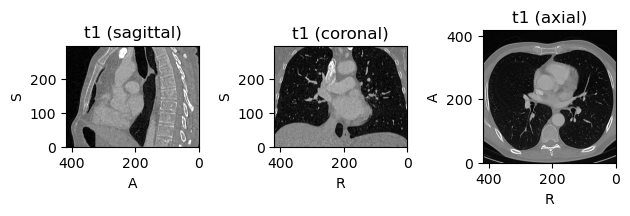

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2170026


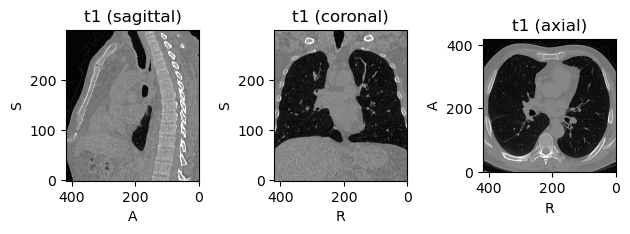

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2187927


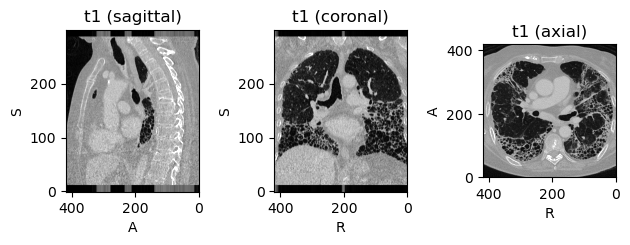

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2207104


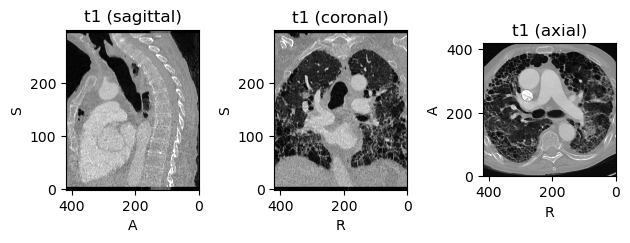

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2211720


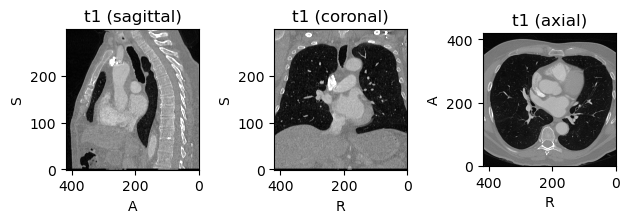

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2214977


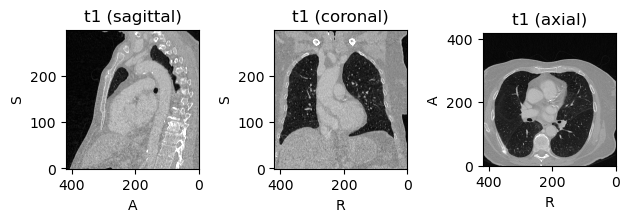

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2219265


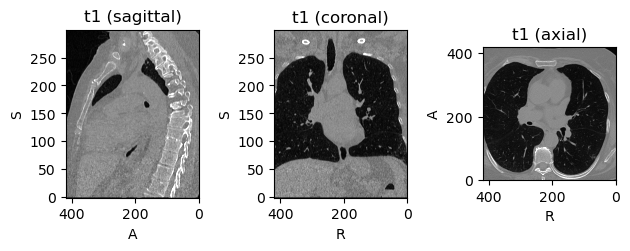

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2219779


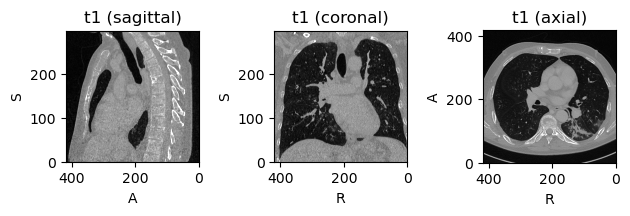

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2227890


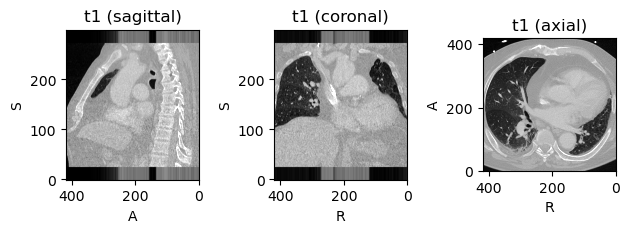

E:\files\Documents\Proyecto Proximity\DR176\DR176_studies\2228670


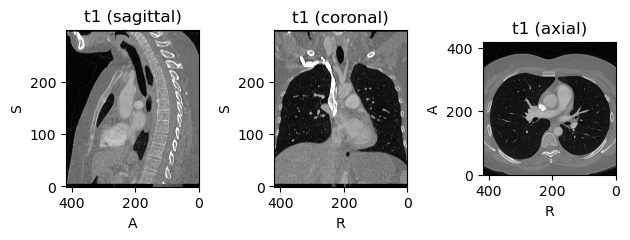

In [4]:


dataset = ProximityCTDataset(DR176_CT_PATH, DR176_LABELS_PATH)
for i in range(20, 30):
    print(dataset[i]['image_path'])
    dataset[i].plot()

ScalarImage(shape: (1, 277, 277, 211); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 61.8 MiB)


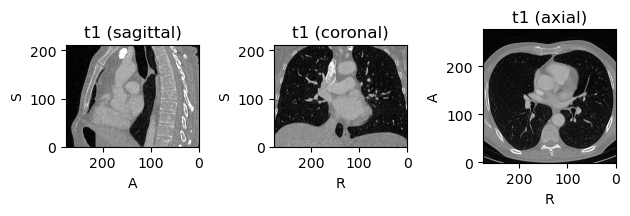

ScalarImage(shape: (1, 265, 265, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 80.4 MiB)


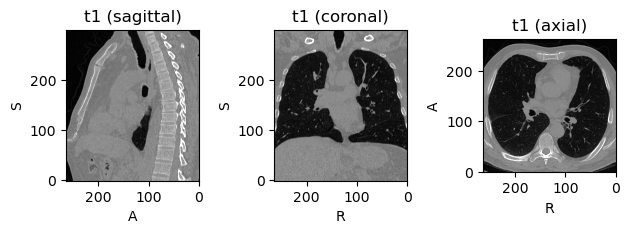

ScalarImage(shape: (1, 247, 247, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 69.8 MiB)


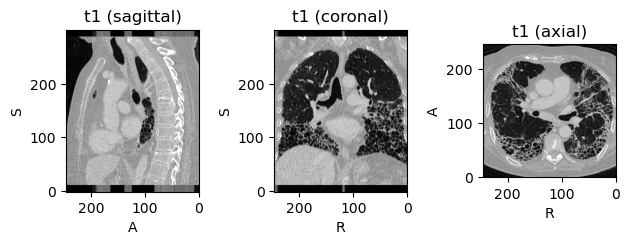

ScalarImage(shape: (1, 251, 251, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 72.1 MiB)


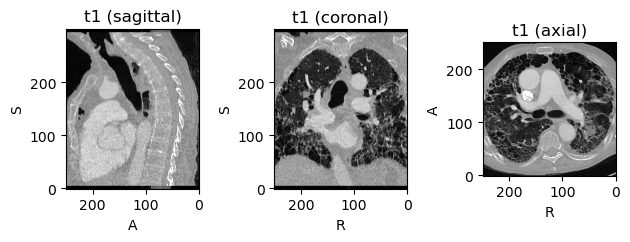

ScalarImage(shape: (1, 285, 285, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 93.0 MiB)


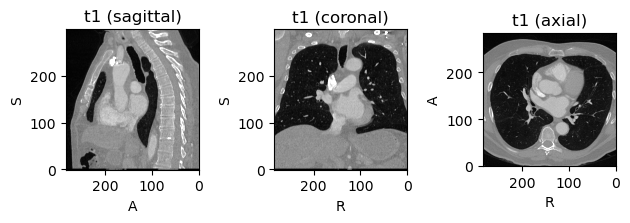

ScalarImage(shape: (1, 288, 288, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 94.9 MiB)


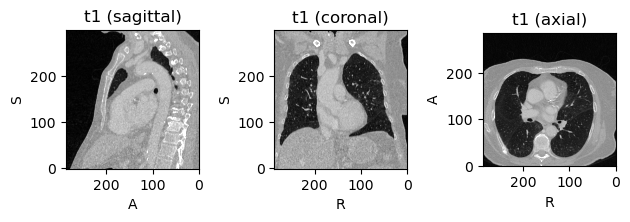

ScalarImage(shape: (1, 238, 238, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 64.8 MiB)


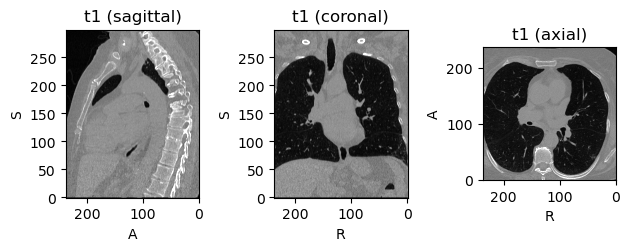

ScalarImage(shape: (1, 305, 305, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 106.5 MiB)


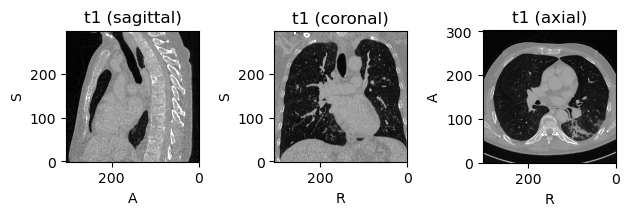

ScalarImage(shape: (1, 268, 268, 302); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 82.7 MiB)


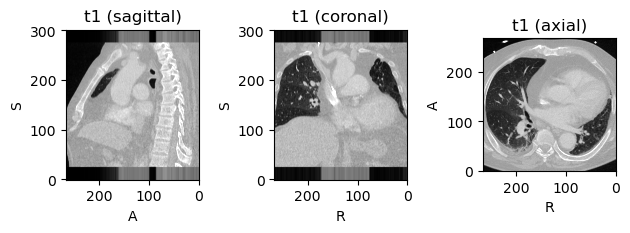

ScalarImage(shape: (1, 255, 255, 300); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 74.4 MiB)


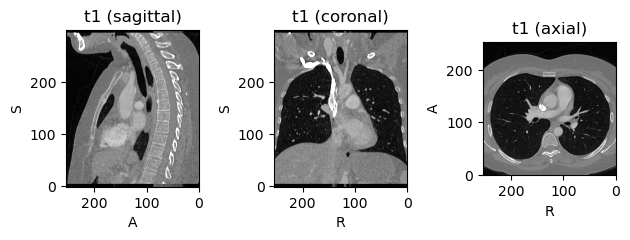

In [19]:
dataset = ProximityCTDataset(DR176_CT_PATH, DR176_LABELS_PATH)
for i in range(20, 30):
    print(dataset[i]['t1'])
    dataset[i].plot()

In [36]:
from torch.utils.data import random_split, DataLoader
import multiprocessing

num_workers = multiprocessing.cpu_count()

training_split_ratio = 0.7

subject_list = [dirname for dirname in os.listdir(DR176_CT_PATH)]

num_subjects = len(subject_list)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = (num_training_subjects, num_validation_subjects)

training_subjects, validation_subjects = torch.utils.data.random_split(subject_list, num_split_subjects)

dataset = ProximityCTDataset(DR176_CT_PATH, subject_list, DR176_LABELS_PATH)

training_set = ProximityCTDataset(DR176_CT_PATH, training_subjects, DR176_LABELS_PATH)

validation_set = ProximityCTDataset(DR176_CT_PATH, validation_subjects, DR176_LABELS_PATH)

training_batch_size = 2
validation_batch_size = training_batch_size

def collate(batch):
    data = []
    labels = []
    for s in batch:
        data.append(s['t1']['data'].squeeze(0))
        labels.append(s['labels_as_vector'])
    return torch.stack(data), torch.tensor(labels)

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=0,
)

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


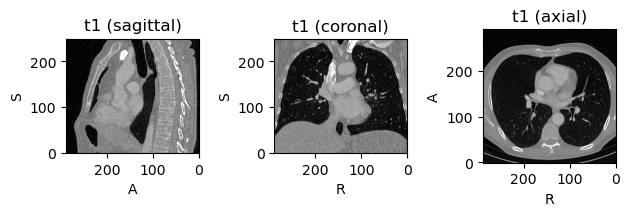

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


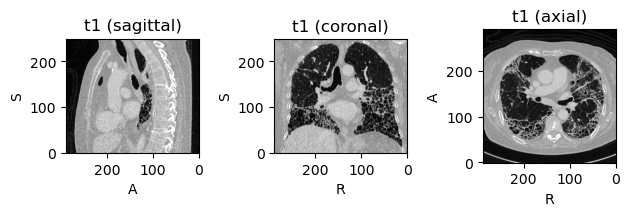

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


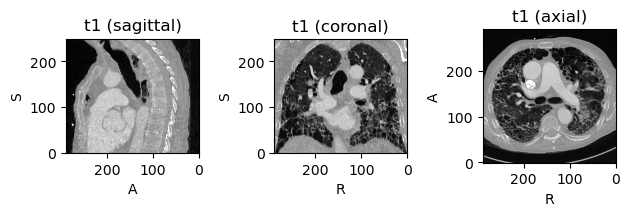

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


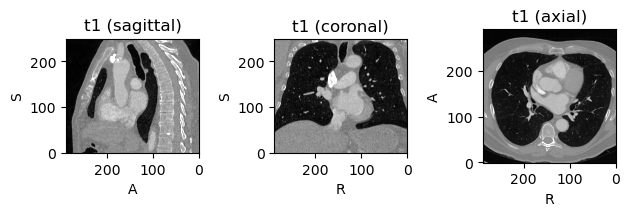

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


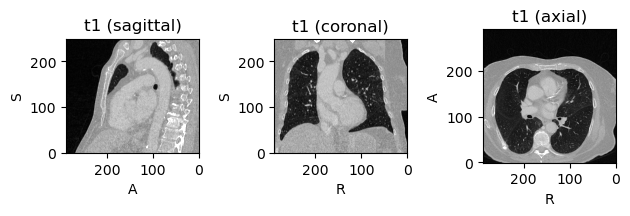

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


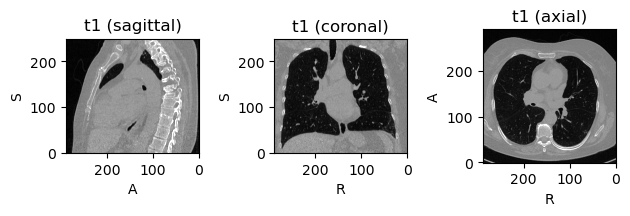

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


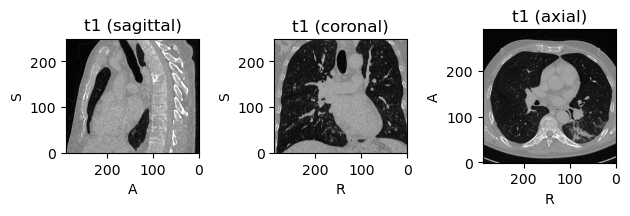

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


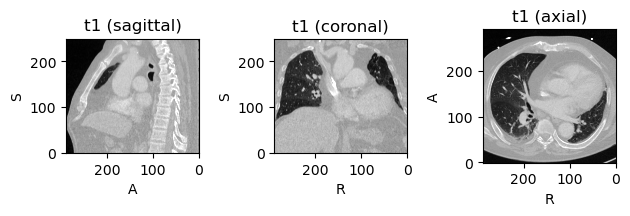

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


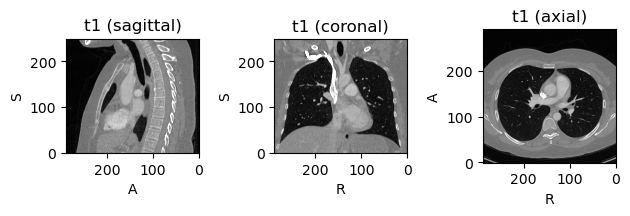

ScalarImage(shape: (1, 290, 290, 249); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 79.9 MiB)


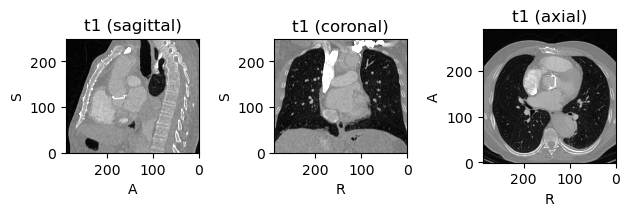

In [34]:
for i in range(20, 30):
    print(dataset[i]['t1'])
    dataset[i].plot()

In [37]:
print(len(training_set))
print(len(validation_set))
b = next(iter(training_loader))

87
41


In [39]:
print(type(b[0]))
print(b[0].shape)
print(b[0])
print(type(b[1]))
print(b[1].shape)
print(b[1])

<class 'torch.Tensor'>
torch.Size([2, 290, 290, 249])
tensor([[[[-1.4872, -1.4223, -1.4671,  ..., -1.2454, -1.3775, -1.4559],
          [-1.3954, -1.2633, -1.3910,  ..., -1.3551, -1.3932, -1.4044],
          [-1.4178, -1.4939, -1.3775,  ..., -1.3842, -1.4962, -1.5544],
          ...,
          [-1.2835, -1.5074, -1.5275,  ..., -1.4738, -1.5275, -1.5253],
          [-1.4939, -1.5387, -1.5186,  ..., -1.5253, -1.6484, -1.6283],
          [-1.4268, -1.3663, -1.3036,  ..., -1.6305, -1.5454, -1.4156]],

         [[-1.4648, -1.4962, -1.3910,  ..., -1.5365, -1.5723, -1.4626],
          [-1.5656, -1.4738, -1.4536,  ..., -1.5320, -1.4447, -1.3865],
          [-1.2924, -1.5141, -1.5410,  ..., -1.4693, -1.4425, -1.5051],
          ...,
          [-1.6126, -1.6440, -1.6171,  ..., -1.5365, -1.6216, -1.6171],
          [-1.6014, -1.5678, -1.5790,  ..., -1.5813, -1.4671, -1.3910],
          [-1.4939, -1.4895, -1.1447,  ..., -1.3641, -1.3372, -1.5007]],

         [[-1.2992, -1.3014, -1.4425,  ..., -1.4

In [32]:
print(type(torch.stack(b[0])))
print(torch.stack(b[0]).shape)
print(torch.stack(b[0]))
print(type(torch.tensor(b[1])))
print(torch.tensor(b[1]).shape)
print(torch.tensor(b[1]))

<class 'torch.Tensor'>
torch.Size([2, 1, 290, 290, 249])
tensor([[[[[-1.0010, -1.0450, -1.0639,  ..., -1.2108, -1.1751, -0.9800],
           [-1.0786, -1.2339, -0.9464,  ..., -0.8856, -0.8709, -1.2024],
           [-0.8688, -0.8709, -0.8940,  ..., -1.2129, -1.1562, -1.1478],
           ...,
           [-1.2737, -1.2947, -1.2465,  ..., -1.3241, -1.3556, -1.3178],
           [-1.3052, -1.2213, -1.1688,  ..., -1.2989, -1.3262, -1.2444],
           [-1.2297, -1.3073, -1.3157,  ..., -1.3073, -1.2402, -1.3073]],

          [[-1.2570, -1.0115, -1.0283,  ..., -1.0387, -1.1856, -0.9527],
           [-1.2255, -1.2297, -1.1374,  ..., -1.0429, -1.0031, -1.1017],
           [-1.1835, -1.0954, -1.0870,  ..., -0.9569, -0.9779, -1.0178],
           ...,
           [-1.2926, -1.1919, -1.2297,  ..., -1.2821, -1.2192, -1.2297],
           [-1.2108, -1.2611, -1.3115,  ..., -1.2339, -1.1982, -1.2653],
           [-1.2150, -1.2339, -1.2632,  ..., -1.3367, -1.3472, -1.3493]],

          [[-1.1206, -1.1311, -

In [11]:
np.array([1, 0, 0])

array([1, 0, 0])

In [1]:
import torch
import torch.nn as nn
from transformers import ConvNextImageProcessor, ResNetForImageClassification, ResNetConfig
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from torchvision import models, utils
from torchvision.transforms import v2

class CTModel(nn.Module):
    def __init__(self):
        super(CTModel, self).__init__()
        
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*(list(resnet.children())[:-2]))

        #conv input torch.Size([1,83,512,14,14])
        self.reducingconvs = nn.Sequential(
            nn.Conv3d(83, 64, kernel_size = (3,3,3), stride=(3,1,1), padding=0),
            nn.ReLU(),
            
            nn.Conv3d(64, 32, kernel_size = (3,3,3), stride=(3,1,1), padding=0),
            nn.ReLU(),
            
            nn.Conv3d(32, 16, kernel_size = (3,2,2), stride=(3,2,2), padding=0),
            nn.ReLU())
        
        self.fc = nn.Sequential(
            nn.Linear(16*18*3*3, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256), 
            nn.ReLU(True),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128))
        '''
        # Convolutional Layers
        self.conv1 = nn.Sequential( 
            nn.Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(3, 1, 1), padding=0),
            nn.BatchNorm3d(256),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential( 
            nn.Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(3, 1, 1), padding=0),
            nn.BatchNorm3d(128),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential( 
            nn.Conv3d(128, 64, kernel_size=(3, 2, 2), stride=(3, 2, 2), padding=0),
            nn.BatchNorm3d(64),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*4*6*6, 1024)
        )
        

    def old_forward(self, x):

        # ResNet
        x = self.resnet(x)
        
        # Convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Fully Connected Layers
        x = self.fc1(x)

        return x
    '''

    def forward(self, x):
        shape = list(x.size())
        #example shape: [1,83,3,290,290]
        #example shape: [2,83,3,290,290]
        batch_size = int(shape[0])
        x = x.view(batch_size*83,3,290,290)
        x = self.features(x)
        x = x.view(batch_size,83,512,10,10)
        x = self.reducingconvs(x)
        #output is shape [batch_size, 16, 18, 3, 3]
        #print(x.shape)
        x = x.view(batch_size, 16*18*3*3)
        x = self.fc(x)
        return x
        
        

            
    



In [8]:
import gc



#print(torch.cuda.memory_summary(device=None, abbreviated=False))

ct_embedding_model = CTModel()
x = torch.randn(8, 249, 290, 290)


device = torch.device("cuda")
ct_embedding_model.to(device)
x = x.to(device)

with torch.no_grad():
    out = ct_embedding_model(x)

print(out.shape)

ct_embedding_model.cpu()
x.cpu()
del ct_embedding_model, x
gc.collect()
torch.cuda.empty_cache()


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.33 GiB. GPU 0 has a total capacity of 6.00 GiB of which 749.37 MiB is free. Of the allocated memory 4.01 GiB is allocated by PyTorch, and 10.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
out

tensor([[-0.0184, -0.0658,  0.0282,  0.0238,  0.1127, -0.0037,  0.0761,  0.0335,
         -0.0399, -0.0465,  0.0925,  0.0090,  0.0811, -0.0325,  0.0319, -0.0709,
          0.0335, -0.0522, -0.0003, -0.0084,  0.0447,  0.0387,  0.0082,  0.0139,
         -0.0715,  0.0494, -0.0155,  0.0548, -0.0400, -0.0119, -0.1291,  0.0067,
          0.0477,  0.0402,  0.0705,  0.0122, -0.0354,  0.0646, -0.0377, -0.0085,
         -0.0336, -0.0168, -0.0224, -0.0865,  0.0875, -0.0553, -0.0234, -0.0011,
          0.0203, -0.0315,  0.0227, -0.0527, -0.0179, -0.0235,  0.0030, -0.0384,
         -0.0222, -0.0236, -0.0832,  0.0067,  0.0667, -0.0304,  0.0034, -0.0327,
          0.0707,  0.0445, -0.0493, -0.0165, -0.0571,  0.0523,  0.0039, -0.0368,
         -0.0170,  0.0144, -0.0875,  0.0729, -0.0005,  0.0002,  0.0760, -0.0296,
          0.0422, -0.0709,  0.0233, -0.0059,  0.0514,  0.0647,  0.0234,  0.0935,
          0.0512, -0.0502, -0.0355, -0.0034,  0.0810, -0.0603, -0.0450,  0.0117,
         -0.0181, -0.0055,  

In [64]:
import torch.nn.functional as F
output = torch.rand(8, 3)
gt = torch.zeros(8, 3)
print(output)
print(gt)
gt2 = np.abs(output.numpy()-gt.numpy()).mean(axis=1)
print(gt2)
acc = np.ones(8) - gt2
print(acc)

tensor([[0.7503, 0.5726, 0.6242],
        [0.1145, 0.7025, 0.0024],
        [0.2935, 0.3686, 0.8672],
        [0.4854, 0.2722, 0.5874],
        [0.0851, 0.3676, 0.6385],
        [0.4669, 0.4475, 0.8056],
        [0.1202, 0.2475, 0.9840],
        [0.5995, 0.4190, 0.7590]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
[0.6490426  0.27313235 0.50976086 0.44834146 0.36373743 0.57332116
 0.45056963 0.5925107 ]
[0.35095739 0.72686765 0.49023914 0.55165854 0.63626257 0.42667884
 0.54943037 0.4074893 ]


In [72]:
(np.array([1,1,0]) == np.array([1,1,0])).all()

True

In [85]:
pred = np.random.choice((0, 1), (10,3))
target = np.random.choice((0, 1), (10,3))
print(pred)
print(t)
new_mask = [(p == t).all() for (p, t) in zip(pred, target)]
mask = np.where((pred==target))[0]
print(mask)
print(new_mask)
print(target[mask])
print(target[new_mask])

[[0 0 0]
 [0 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 1 0]
 [0 0 1]
 [0 1 1]
 [1 0 1]]
[[0 0 0]
 [1 0 1]
 [0 0 1]
 [0 0 0]
 [1 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [0 0 1]]
[0 0 0 1 1 2 2 3 3 4 4 5 5 6 6 7]
[True, False, False, False, False, False, False, False, False, False]
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 1 0]
 [1 1 0]
 [1 0 1]
 [1 0 1]
 [0 1 1]
 [0 1 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]]
[[0 0 0]]


In [107]:
class A(object):     # deriving from 'object' declares A as a 'new-style-class'
    def foo(self):
        print ("foo")

    def __getitem__(self, idx):
        print('A')
        return idx

class B(A):
    def foo(self):
        super(B, self).foo()   # calls 'A.foo()'

    def re(self, idx):
        return super().[idx]


myB = B()
print(myB.re(1))

SyntaxError: invalid syntax (528959533.py, line 14)

In [66]:
from torch.utils.data import Dataset, random_split, RandomSampler, BatchSampler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import time
import logging

random.seed(42)

logging.basicConfig(level=logging.INFO)

class TripletModel:
    def __init__(
        self,
        model,
        mode='HN',
        seed=0,
    ):
        """
        mode: (negative sampling) "random" or "HN"
        estimator: "Linear" or "net"
        """

        # dim latent space
        #self.factor = factor 

        #VSE++
        #self.batch_size = 30  

        #ResNet18
        self.batch_size = 8

        #VSE++
        #self.epochs = 30

        # ResNet18
        self.epochs = 1
        
        self.model = model
        
        self.device = 'cpu'
        
        if not torch.cuda.is_available():
            self.device = torch.device("cuda")
            self.model.to(self.device)
        
        #VSE++
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.0002)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=15, gamma=0.1)

        # FF net or LINEAR
        #self.estimator = estimator
        
        # Save checkpoints to this path
        self.checkpoint_path = TRIPLET_MODELS_PATH
        
        # Negative sampling: 'HN' or 'random'
        self.mode = mode
        
        # Triplet loss' alpha
        self.alpha = 0.2
        
        self.seed = seed

        # Set seeds
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    def prepare_batch(self, batch):
        inputs = batch['t1'][tio.DATA].to(self.device)
        labels = batch['labels_as_vector'][tio.DATA].to(self.device)
        return inputs, labels

    def get_positive_negative_pairs(self, emb_list, id_list):
        logging.info(f"Generating triplets for batch {id_list}")
        assert(len(id_list) > 0)
        positives_dict = dict() # positives_dict := { anchor_id : list_of_positives_ids }
        negatives_dict = dict() # negatives_dict _= { anchor_id : (ids not contained in list_of_positives_ids) }
        positive_candidates_label_vectors = list(np.array(self.labels_df.iloc[ids_list].iloc[:,1:4], dtype=int))
        
        for j in ids_list:
            positives_list = list()
            negatives_list = list()
            anchor_label_vector = list(np.array(self.labels_df.iloc[j].iloc[1:4], dtype=int))
            for i, positive_candidate_label_vector in zip(ids_list, positive_candidates_label_vectors):
                if i == j:
                    continue
                distance = hamming(anchor_label_vector, positive_candidate_label_vector)
                if distance == 0.0:
                    positives_list.append(i)
                else:
                    negatives_list.append(i)
            positives_dict[j] = positives_list
            negatives_dict[j] = negatives_list
        
        positive_pairs = list() # positive_pairs := list of pairs [anchor_id, positive_example_id]
        negative_candidates = dict() # negative_candidates := dict of form {anchor_id : [negative_example_1, negative_example_2, ...]]}
        for k in positives_dict:
            if len(positives_dict[k]) > 0:
                positive_pairs.append([k, random.choice(positives_dict[k])])
            else:
                logging.info(f"Could not construct a positive pair for anchor ID {k} in this batch. Skipping...")
                continue
            if len(negatives_dict[k]) > 0:
                negative_candidates[k] = negatives_dict[k]
            else:
                logging.info(f"Could not construct a negative pair for anchor ID {k} in this batch. Skipping...")
                continue
        return positive_pairs, negative_candidates
    
    def get_triplets(self, emb_list, id_list):
        # construct positive pairs and negative-compatibles from the data points in the mini-batch
        #print('ids_list:', ids_list)
        positive_pairs, negative_compatibles = self.get_positive_negative_pairs(emb_list, ids_list)
        triplets = list()

        if len(positive_pairs) == 0 or len(negative_compatibles) == 0:
            logging.warning(f"Cannot build triplets from current batch! {len(positive_pairs)} positives and {len(negative_compatibles)} negative pair candidates found.")
            return None #skip batch

        if self.mode == "random":
            negative_pairs = [[a, random.choice(negative_compatibles[neg_id])] for (a, neg_id) in negative_compatibles]
            # a_p and a_n should always be the same value, so it doesn't matter which one we choose to build the triplet
            triplets = torch.tensor([[a_p, p, n] for ([a_p, p], [a_n, n]) in zip(positive_pairs, negative_pairs)])

        elif self.mode == "HN":
            anchors_list = [a for (a, _) in positive_pairs]
            #embeddings = self.dataset.get_embeddings(ids_list)
            anchors_embs = self.dataset.get_embeddings(anchors_list)
            negative_pairs = list()
            for anchor_id, anchor_emb in zip(anchors_list, anchors_embs):
                negatives_compatibles_ids = negative_compatibles[anchor_id]
                n_compatibles = len(negatives_compatibles_ids)
                negatives_compatibles_embs = self.dataset.get_embeddings(negatives_compatibles_ids)
                negatives_compatibles_embs = negatives_compatibles_embs.squeeze(1)
                anchor_emb_repeat = anchor_emb.repeat(n_compatibles, 1)
                #anchor_emb_repeat = torch.fill(torch.empty(n_compatibles), anchor_emb)
                a_n_pairwise_similarities = torch.nn.functional.cosine_similarity(anchor_emb_repeat, negatives_compatibles_embs)
                most_similar_id = torch.argmax(a_n_pairwise_similarities)
                negative_pairs.append([anchor_id, negatives_compatibles_ids[most_similar_id]])
                #print('\nSTART ANCHOR\n')
                #print('anchors_list', anchors_list)
                #print('anchor_id', anchor_id)
                #print('negatives_compatibles_ids', negatives_compatibles_ids)
                #print('anchor_emb_repeat', anchor_emb_repeat.shape, anchor_emb_repeat)
                #print('negatives_compatibles_embs', negatives_compatibles_embs.shape, negatives_compatibles_embs)
                #print('a_n_pairwise_similarities', a_n_pairwise_similarities)
                #print('most_similar_id', most_similar_id)
                #print('\nEND ANCHOR\n')
            # a_p and a_n should always be the same value, so it doesn't matter which one we choose to build the triplet
            triplets = torch.tensor([[a_p, p, n] for ([a_p, p], [a_n, n]) in zip(positive_pairs, negative_pairs)])
        if self.device:
            triplets = triplets.to(self.device)
        return triplets
        
        
    def training(self, dataset, train_frac=0.6, batch_size=8, epochs=1):
        """
        Training process
        """
        
        assert train_frac > 0.0 and 1.0 >= train_frac
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        
        # Define the sizes of train, validation, and test sets
        train_size = int(train_frac * len(self.dataset))  # percentage of the data for training
        val_size = int((1.0 - train_frac)/1 * len(self.dataset)) # half of the remaining for validation
        test_size = len(self.dataset) - train_size - val_size  # the rest of the remaining for testing

        '''
        If necessary, adjust the size of the training set when the sum of 
        the sizes of the three sets differs from the total dataset size.
        '''
        size_diff = len(self.dataset) - train_size - val_size - test_size
        train_size += size_diff

        # Use random_split to split the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset=self.dataset, lengths=[train_size, val_size, test_size], generator=torch.Generator().manual_seed(self.seed))
        
        # Create a RandomSampler with a predetermined seed and no replacement
        #self.training_sampler = RandomSampler(self.train_dataset, replacement=False, generator=torch.Generator().manual_seed(seed))
        self.validation_sampler = RandomSampler(self.val_dataset, replacement=False, generator=torch.Generator().manual_seed(self.seed))
        self.test_sampler = RandomSampler(self.test_dataset, replacement=False, generator=torch.Generator().manual_seed(self.seed))

        #self.train_batch_sampler = BatchSampler(sampler=self.training_sampler, batch_size=self.batch_size, drop_last=True)
        self.val_batch_sampler = BatchSampler(sampler=self.validation_sampler, batch_size=len(self.val_dataset), drop_last=True)
        self.test_batch_sampler = BatchSampler(sampler=self.test_sampler, batch_size=len(self.test_dataset), drop_last=True)
        
        # self.dataset.shape := (number of data points, number of classes)
        #self.n_classes = self.dataset.shape[1]

        self.recalls = [] # recall 1, 10, 25
        self.loss_per_epoch = []
        self.step_losses = []
        self.val_loss_per_epoch = []
        
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.tb_writer = SummaryWriter(os.path.join(TRIPLET_MODELS_PATH, "runs", "ct_retrieval_trainer_{}".format(timestamp)))
        
        start_time = time.time()
        
        for epoch in range(self.epochs):
            logging.info(f"\n--------------------------------\nEpoch {epoch+1} of {self.epochs}\n--------------------------------\n")

            batch_counter = 0 # counter of processed batches across training
            
            epoch_losses = list()
            
            # change the random seed and reconstruct training_sampler and train_batch_sampler at each epoch
            # this way we can assemble never-before-seen triplets to train on.
            self.training_sampler = RandomSampler(self.train_dataset, replacement=False, generator=torch.Generator().manual_seed(self.seed + epoch))
            self.train_batch_sampler = BatchSampler(sampler=self.training_sampler, batch_size=self.batch_size, drop_last=True)

            # recalculate dataset embeddings at this epoch
            with torch.no_grad():
                train_dataset_embeddings = []
                for sample in self.train_dataset:
                train_dataset_embeddings.append(self.model(sample['t1'][tio.DATA].to(self.device)))
                train_dataset_embeddings = torch.stack(train_dataset_embeddings).to(self.device)
            #dataset_embeddings = self.dataset.get_updated_embeddings(self.model, self.device)

            self.model.train(True)
            for batch_index, training_batch in enumerate(self.train_batch_sampler):
                batch_counter += 1

                self.optimizer.zero_grad()
                
                logging.info(f"=> Batch {batch_counter}:")

                batch_volumes, batch_labels = self.prepare_batch(training_batch)
                batch_triplets = self.get_triplets(train_dataset_embeddings, batch_labels)
                #batch_triplets = [[batch_id_map[a], batch_id_map[p], batch_id_map[n]] for [a, p, n] in batch_triplets.tolist()]
                batch_triplets = torch.tensor(batch_triplets)
                #print('training_batch:', training_batch)
                #print('dataset_batch_ids:', dataset_batch_ids)
                #print('batch_triplets:', batch_triplets)
                
                if batch_triplets is None:
                    # skip empty batch
                    continue
                
                # perform forward pass over all samples in the batch
                outputs = self.model(batch_embeddings)

                # map the dataset IDs referenced in the triplets to the indices in the batched model output
                #print('batch_ids:', mini_batch)
                #print('triplets before mapping:\n', triplets)
                #triplets = self._map_triplets(mini_batch, triplets)
                #print('triplets after mapping:\n', triplets)
                
                # calculate loss and gradients
                # IMPORTANT: the loss is calculated for each triplet (3-tuples of samples), therefore,
                # if there is a sample which is not part of a triplet, then it will not be needed in
                # calculation.
                batch_loss = self.loss(outputs, batch_triplets, alpha=self.alpha)
                # batch_loss.requires_grad = True
                batch_loss.backward()

                # update model weights
                self.optimizer.step()

                self.tb_writer.add_scalar('Steps: Loss/train', batch_loss, global_step=batch_counter)
                
                epoch_losses.append(batch_loss)
                self.step_losses.append(batch_loss)
                logging.info(f"Batch {batch_counter} loss: {round(batch_loss.item(), 4)}")
            
            # finished iterating the batches
            epoch_mean_loss = (sum(epoch_losses) / len(epoch_losses)).item()
            self.tb_writer.add_scalar('Epochs: Loss/train', epoch_mean_loss, global_step=epoch+1)
            self.loss_per_epoch.append(epoch_mean_loss)

            logging.info(f'Training loss: {round(epoch_mean_loss, 4)}')
            
            
            # evaluate on validation set
            logging.info("Evaluating...")
            self.model.eval()
            val_epoch_losses = list()
            with torch.no_grad():
                for val_batch_index, val_batch in enumerate(self.val_batch_sampler):

                    val_batch_ids, val_batch_embeddings, val_batch_labels = self.val_dataset[val_batch]

                    val_batch_id_map = dict((i, j) for (i, j) in zip(val_batch_ids.tolist(), val_batch))
                    

                    if self.device is not None:
                        val_batch_embeddings = val_batch_embeddings.to(self.device)
                        
                    val_batch_triplets = self.get_triplets(val_batch_ids.tolist())
                    val_batch_triplets = [[val_batch_id_map[a], val_batch_id_map[p], val_batch_id_map[n]] for [a, p, n] in val_batch_triplets.tolist()]
                    val_batch_triplets = torch.tensor(val_batch_triplets)
                    
                    if val_batch_triplets is None:
                        # skip validation if there was no triplets to evaluate
                        continue

                    # map the dataset IDs referenced in the triplets to the indices in the batched model output

                    #val_triplets = self._map_triplets(val_batch, val_triplets)

                    

                    # perform evaluation on validation data
                    val_outputs = self.model(val_batch_embeddings)

                    # calculate validation loss
                    val_batch_loss = self.loss(val_outputs, val_batch, val_batch_triplets, alpha=self.alpha)
                    val_epoch_losses.append(val_batch_loss)
                    logging.info(f"Validation batch {val_batch_index+1} loss: {round(val_batch_loss.item(), 4)}")
                
                # finished iterating the batches
                val_mean_loss = (sum(val_epoch_losses) / len(val_epoch_losses)).item()
                self.tb_writer.add_scalars(
                    'Training vs. Validation Loss',
                    {
                        'Training': epoch_mean_loss, 
                        'Validation': val_mean_loss,
                    }, 
                    epoch + 1
                )
                self.val_loss_per_epoch.append(val_mean_loss)

                logging.info(f'Validation loss: {round(val_mean_loss, 4)}')
            
                # end batch iteration
            logging.info("Done evaluating.")
            if(self.val_loss_per_epoch[-1] == min(self.val_loss_per_epoch)):
                logging.info("Best validation loss achieved! Saving checkpoint...")
                self.save(
                    epoch,
                    self.loss_per_epoch, 
                    self.step_losses, 
                    self.val_loss_per_epoch, 
                    self.recalls,
                    time.time()-start_time,
                    os.path.join(TRIPLET_CHECKPOINTS_PATH, f'ct_retrieval_trainer_{timestamp}.pth'),
                )
                logging.info("Checkpoint saved.")

            # update optimizer scheduler ater completing an epoch
            self.scheduler.step()
            # end epoch iteration
        #print('train_dataset:', self.train_dataset[0:len(self.train_dataset)][0])
        #print('val_dataset:', self.val_dataset[0:len(self.val_dataset)][0])

    def _map_triplets(self, batch_ids, triplets):
        a_tensor = triplets.select(1, 0)
        p_tensor = triplets.select(1, 1)
        n_tensor = triplets.select(1, 2)
        a_items = [e.item() for e in a_tensor]
        p_items = [e.item() for e in p_tensor]
        n_items = [e.item() for e in n_tensor]
        a_index = list()
        p_index = list()
        n_index = list()
        for (a, p, n) in zip(a_items, p_items, n_items):
            a_index.append(batch_ids.index(a))
            p_index.append(batch_ids.index(p))
            n_index.append(batch_ids.index(n))
        mapped_triplets = torch.tensor([a_index, p_index, n_index])
        mapped_triplets = mapped_triplets.transpose(0, 1)
        return mapped_triplets

    def _max(self, a, b):
        if a > b:
            return a
        return b
    
    def loss(self, embeddings, embeddings_ids, triplets_ids, alpha=0.2):
        
        """
        for computing the triplet loss [alpha + negative_similarity - positive_similarity]_{+}
        """
        anchors_ids = torch.select(triplets_ids, 1, 0).tolist()
        positives_ids = torch.select(triplets_ids, 1, 1).tolist()
        negatives_ids = torch.select(triplets_ids, 1, 2).tolist()

        ids_map = dict((j, i) for i, j in enumerate(embeddings_ids))
        
        anchors = embeddings[[ids_map[a] for a in anchors_ids]]
        positives = embeddings[[ids_map[p] for p in positives_ids]]
        negatives = embeddings[[ids_map[n] for n in negatives_ids]]
        
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        
        positive_similarities = cos(anchors, positives)
        negative_similarities = cos(anchors, negatives)
        
        unrectified_batch_loss = alpha + negative_similarities - positive_similarities
        rectified_batch_loss = unrectified_batch_loss.detach().map_(torch.zeros(len(unrectified_batch_loss)), self._max)
        #rectified_batch_loss = torch.func.vmap(torch.max)(unrectified_batch_loss, torch.tensor(0))
        batch_loss = torch.mean(rectified_batch_loss)
        if self.device:
            batch_loss = batch_loss.to(device)
        return batch_loss
    
    def save(self, epoch, epoch_loss, step_loss, val_loss, recalls, running_time, directory):
        """
        For saving logs of the experiment
        """
        
        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.scheduler.state_dict(),
                'epoch': epoch,
                'epoch_loss': epoch_loss,
                'step_loss': step_loss,
                'val_loss': val_loss,
                'recalls': recalls,
                'running_time': running_time,
            },
            directory
        )

In [29]:
'''    
        def predict(self,query,split):
        """
        the split defines where we are going to search
        """
        if type(query) is not list:
            query= [query]

        i_input = self.visual_encoder(tf.nn.embedding_lookup(visual_matrix, query))
        if split=="val":
                c_eval= self.visual_encoder(visual_matrix[self.val_ids])
        if split=="test":
                c_eval= self.visual_encoder(visual_matrix[self.test_ids])
        if split=="train":
                c_eval=self.visual_encoder(visual_matrix[self.train_ids])

        rating= tf.matmul(i_input, tf.transpose(c_eval) )
        return np.reshape(rating, [-1])

    def metric(self, split, k=10):
        """
        to compute metrics
        """
        if split == "val":
            ids, gt = self.val_ids, self.labels_val
        if split == "test":
            ids, gt = self.test_ids, self.labels_test

        metric=0

        for i in range(len(ids)): #querys
            top= np.argsort(self.predict(ids[i],split))[::-1][1:k+1] #first one must be the query
            #get labels
            prediction= [gt[j] for j in top]
            metric+=recall(gt[i], prediction)
        return metric/len(ids) #average

    def inference(self):
        """
        testing phase
        """
        results=(self.metric("test",k=1), self.metric("test",k=10), self.metric("test",k=25))
        print(results)
        np.save(self.DIS_MODEL_FILE+"test_metrics.npy", np.array([results], dtype=object) )
'''

'    \n        def predict(self,query,split):\n        """\n        the split defines where we are going to search\n        """\n        if type(query) is not list:\n            query= [query]\n\n        i_input = self.visual_encoder(tf.nn.embedding_lookup(visual_matrix, query))\n        if split=="val":\n                c_eval= self.visual_encoder(visual_matrix[self.val_ids])\n        if split=="test":\n                c_eval= self.visual_encoder(visual_matrix[self.test_ids])\n        if split=="train":\n                c_eval=self.visual_encoder(visual_matrix[self.train_ids])\n\n        rating= tf.matmul(i_input, tf.transpose(c_eval) )\n        return np.reshape(rating, [-1])\n\n    def metric(self, split, k=10):\n        """\n        to compute metrics\n        """\n        if split == "val":\n            ids, gt = self.val_ids, self.labels_val\n        if split == "test":\n            ids, gt = self.test_ids, self.labels_test\n\n        metric=0\n\n        for i in range(len(ids)):

In [65]:
ct_embedding_model = CTModel()
triplet_model = TripletModel(model=ct_embedding_model, mode='HN', seed=42)

# Create an instance of the dataset
dr70_dataset = CustomDataset(CT_RESNET18_EMBEDDINGS_PATH, DR70_LABELS_PATH)

triplet_model.training(dataset=dr70_dataset, train_frac=0.7, batch_size=8, epochs=10)

INFO:root:
--------------------------------
Epoch 1 of 10
--------------------------------

INFO:root:=> Batch 1:
INFO:root:Generating triplets for batch [67, 47, 18, 55, 39, 12, 45, 28]
INFO:root:Could not construct a positive pair for anchor ID 45 in this batch. Skipping...
INFO:root:Batch 1 loss: 0.2585
INFO:root:=> Batch 2:
INFO:root:Generating triplets for batch [50, 48, 53, 62, 15, 44, 19, 11]
INFO:root:Batch 2 loss: 0.2311
INFO:root:=> Batch 3:
INFO:root:Generating triplets for batch [25, 34, 56, 6, 41, 31, 21, 61]
INFO:root:Could not construct a positive pair for anchor ID 25 in this batch. Skipping...
INFO:root:Could not construct a positive pair for anchor ID 56 in this batch. Skipping...
INFO:root:Batch 3 loss: 0.2167
INFO:root:=> Batch 4:
INFO:root:Generating triplets for batch [43, 3, 42, 35, 68, 32, 30, 23]
INFO:root:Could not construct a positive pair for anchor ID 35 in this batch. Skipping...
INFO:root:Batch 4 loss: 0.2619
INFO:root:=> Batch 5:
INFO:root:Generating tri

train_dataset: tensor([39, 32, 18, 61, 60, 12, 67, 55, 15, 62, 14,  3, 53, 31,  4, 19, 47, 44,
        21, 25, 49, 41, 23, 26, 68, 58, 30, 42,  6, 48, 57, 16, 17,  8, 28, 43,
        65, 11, 50,  0, 40, 63, 35,  9, 51, 56, 45, 34])
val_dataset: tensor([10, 66, 29, 38, 52, 64,  7, 20, 37, 36, 27, 13, 33, 59,  5, 46,  1, 54,
        22,  2])
